In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
import sys

# Change working directory to ../.. only if not already there
if not hasattr(sys, "_parent_dir_set"):
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if os.getcwd() != parent_dir:
        os.chdir(parent_dir)
    sys._parent_dir_set = parent_dir
else:
    parent_dir = sys._parent_dir_set
# Add parent_dir to sys.path only if not already present
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import numpy as np
from SRtools import sr_mcmc as srmc
from SRtools import deathTimesDataSet as dtds
import matplotlib.pyplot as plt

 # Raw Data loading and plotting

In [2]:
rawDataFile = 'Rawfiles/Drosophila.csv'


In [3]:

properties = ["Genotype","Cage","Treatment"]
events_col ='Dead'
death_times_column ='Age'
selection_criteria = {'Genotype':'Line: 217','Treatment':'8 CONTINUOUS'}
cleanedDataFile = 'Cleaned_datasets/Drosophila_217.csv'
cohorts = dtds.DatasetCollection(file_names=rawDataFile,properties=properties,events_column=events_col,death_times_column=death_times_column)

In [4]:
print(cohorts.datasets.keys())

dict_keys(['Genotype:_Line: 136,Cage:_(1),Treatment:_2', 'Genotype:_Line: 707,Cage:_(1),Treatment:_2', 'Genotype:_Line: 239,Cage:_(10),Treatment:_2', 'Genotype:_Line: 441,Cage:_(10),Treatment:_2', 'Genotype:_Line: 705,Cage:_(11),Treatment:_2', 'Genotype:_Line: 136,Cage:_(12),Treatment:_2', 'Genotype:_Line: 195,Cage:_(12),Treatment:_2', 'Genotype:_Line: 335,Cage:_(12),Treatment:_2', 'Genotype:_Line: 362,Cage:_(13),Treatment:_2', 'Genotype:_Line: 441,Cage:_(13),Treatment:_2', 'Genotype:_Line: 136,Cage:_(14),Treatment:_2', 'Genotype:_Line: 853,Cage:_(14),Treatment:_2', 'Genotype:_Line: 195,Cage:_(15),Treatment:_2', 'Genotype:_Line: 362,Cage:_(15),Treatment:_2', 'Genotype:_Line: 239,Cage:_(16),Treatment:_2', 'Genotype:_Line: 335,Cage:_(16),Treatment:_2', 'Genotype:_Line: 705,Cage:_(16),Treatment:_2', 'Genotype:_Line: 707,Cage:_(16),Treatment:_2', 'Genotype:_Line: 853,Cage:_(16),Treatment:_2', 'Genotype:_Line: 195,Cage:_(17),Treatment:_2', 'Genotype:_Line: 217,Cage:_(17),Treatment:_2', 'Gen

['Line: 105', 'Line: 705', 'Line: 239', 'Line: 707', 'Line: 136', 'Line: 441', 'Line: 335', 'Line: 853', 'Line: 362', 'Line: 195', 'Line: 217']


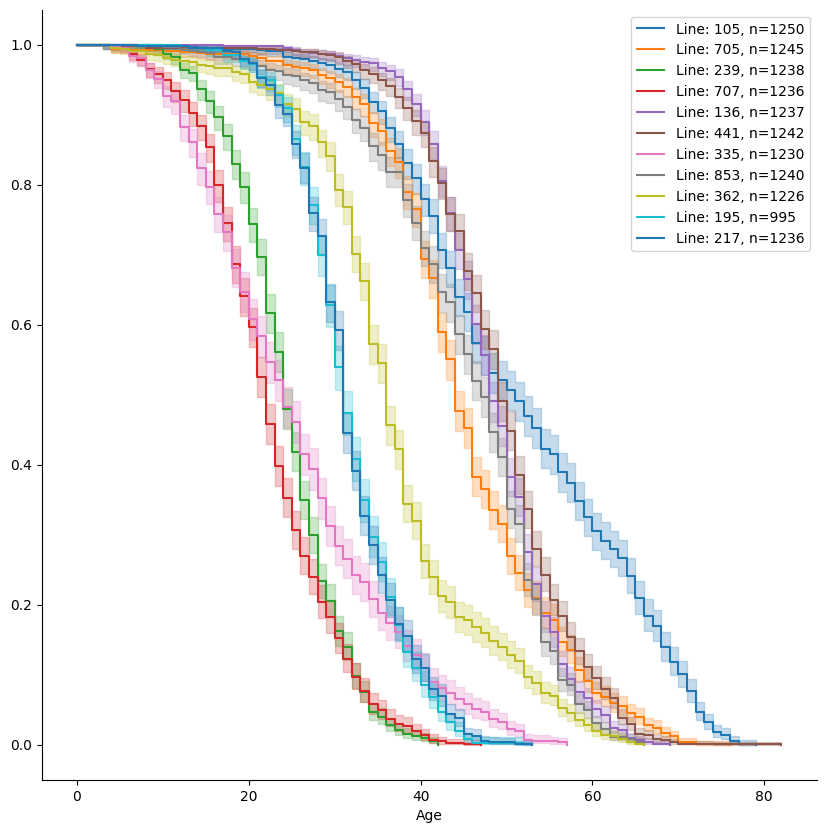

In [5]:
prop = 'Genotype'
prop_values =[]
for dataset in cohorts.datasets.values():
    prop_values.append(dataset.properties[prop][0])
prop_values = list(set(prop_values))
print(prop_values)
fig, ax = plt.subplots(1,1,figsize=(10,10))
for value in prop_values:
    cohort=cohorts.get_combined_dataset(properties=[prop,'Treatment'],values=[value,'8 CONTINUOUS'])
    cohort.plotSurvival(ax=ax,label=f"{value}, n={cohort.n}")

# Choosing only relevant cohorts and sanity checking
We aggragate all the relevant cohorts (controls) and sample with the same size distribution as the original cohorts. We look to see the spread as a sanity check.
We then calculate the steepnes (ML/IQR) and longevity (ML) of each sampled and data cohorts.

In [6]:
print(list(selection_criteria.values()))

['Line: 217', '8 CONTINUOUS']


In [7]:
agragated_cohort = cohorts.get_combined_dataset(properties=list(selection_criteria.keys()),values=list(selection_criteria.values()))
print(agragated_cohort.n)

1236


In [8]:
selected_cohorts = cohorts.getSubset(properties=list(selection_criteria.keys()),values=list(selection_criteria.values()))
print(selected_cohorts.nDatasets())

10


array([<Axes: title={'center': 'Sampled datasets n datasets=100'}, xlabel='Age'>,
       <Axes: title={'center': 'Data datasets'}, xlabel='Age'>],
      dtype=object)

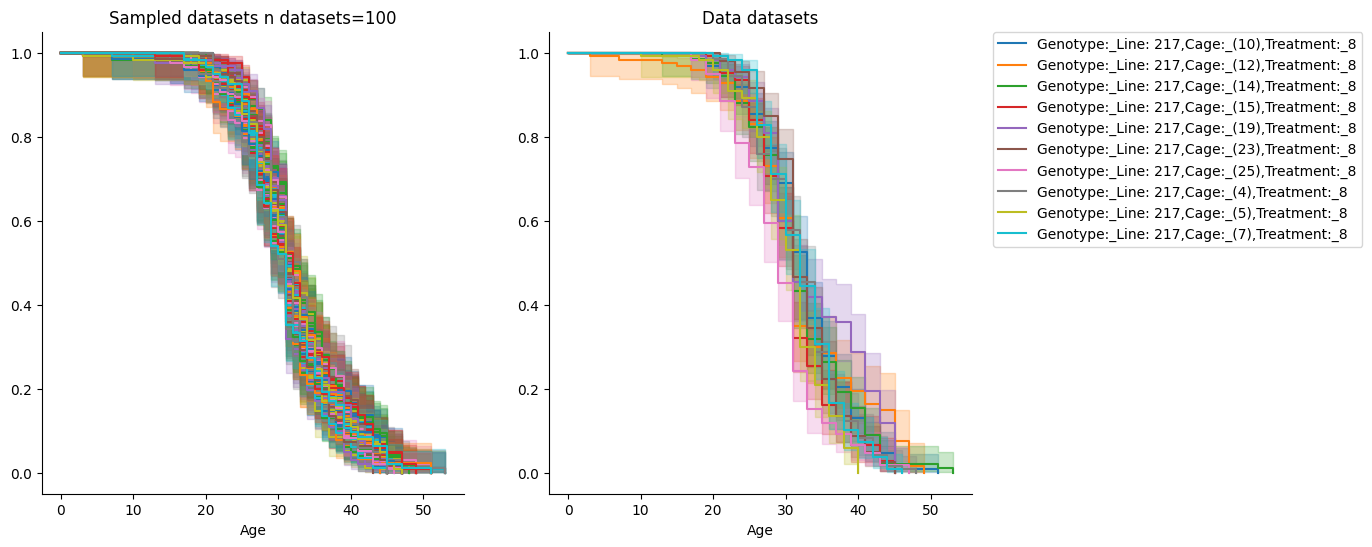

In [9]:
selected_cohorts.plotSurvivalComparison()

<Axes: title={'center': 'Median lifetime vs Steepness Data and sampled datasets'}, xlabel='Median lifetime', ylabel='Steepness'>

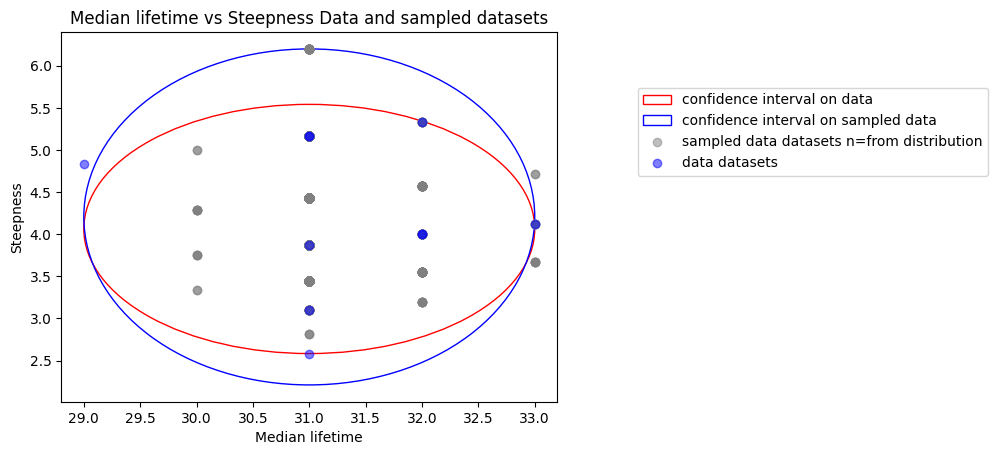

In [10]:
selected_cohorts.drawConfidenceEllipse(data_percentile=100,sampled_percentile=99.9)

# Cleaning outliers 
We remove outliers that are outside the sampled cohorts confidence interval  (we do each axis saparately so the elipses are a bit missleading). We the replot the spreads of the cleaned data vs sampled data (we smaple from the cleaned cohorts)

In [11]:
cleaned_cohorts = selected_cohorts.clean_DatasetCollection(n_samples=1000,sampled_percentile=99.9)

Removing dataset Genotype:_Line: 217,Cage:_(10),Treatment:_8 with median lifetime 33.0 and steepness 4.125
Removing dataset Genotype:_Line: 217,Cage:_(25),Treatment:_8 with median lifetime 29.0 and steepness 4.833333333333333


<Axes: title={'center': 'Median lifetime vs Steepness Data and sampled datasets'}, xlabel='Median lifetime', ylabel='Steepness'>

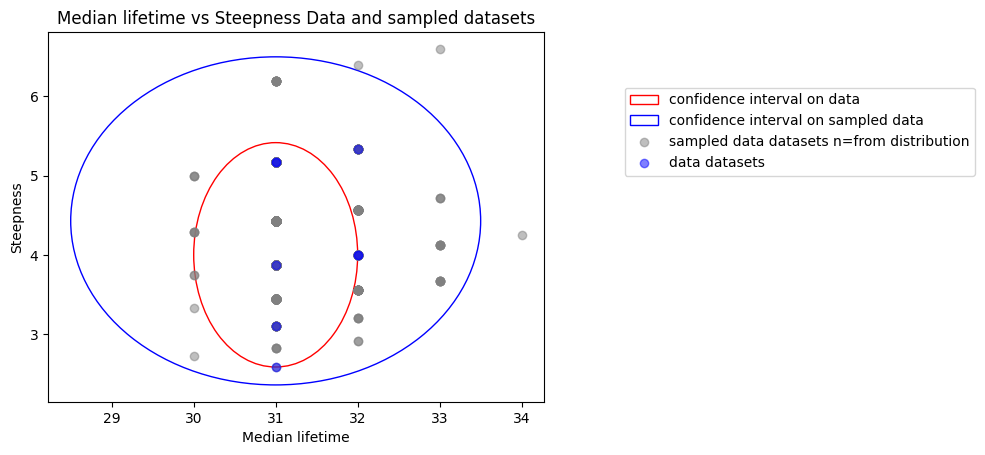

In [12]:
cleaned_cohorts.drawConfidenceEllipse(data_percentile=100,sampled_percentile=99.9)

array([<Axes: title={'center': 'Sampled datasets n datasets=100'}, xlabel='Age'>,
       <Axes: title={'center': 'Data datasets'}, xlabel='Age'>],
      dtype=object)

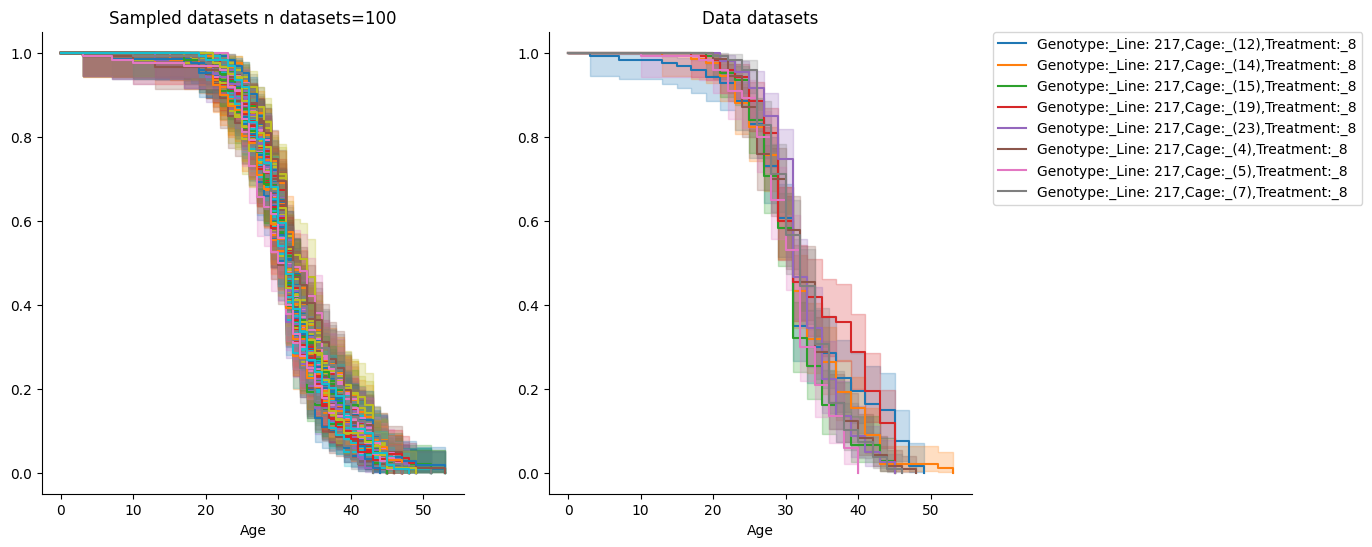

In [13]:
cleaned_cohorts.plotSurvivalComparison()

In [14]:
combined_cleaned_cohorts = cleaned_cohorts.get_combined_dataset()
print(combined_cleaned_cohorts.n)

989


In [15]:
combined_cleaned_cohorts.toCsv(cleanedDataFile)